In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import urllib.parse
import seaborn as sns
from tqdm import tqdm
import src.data.data_loader as data_loader

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()

---

In [3]:
articles.size

4604

In [4]:
links.head()

linkSource     linkTarget
0  Áedán mac Gabráin           Bede
1  Áedán mac Gabráin        Columba
2  Áedán mac Gabráin      Dál Riata
3  Áedán mac Gabráin  Great Britain
4  Áedán mac Gabráin        Ireland

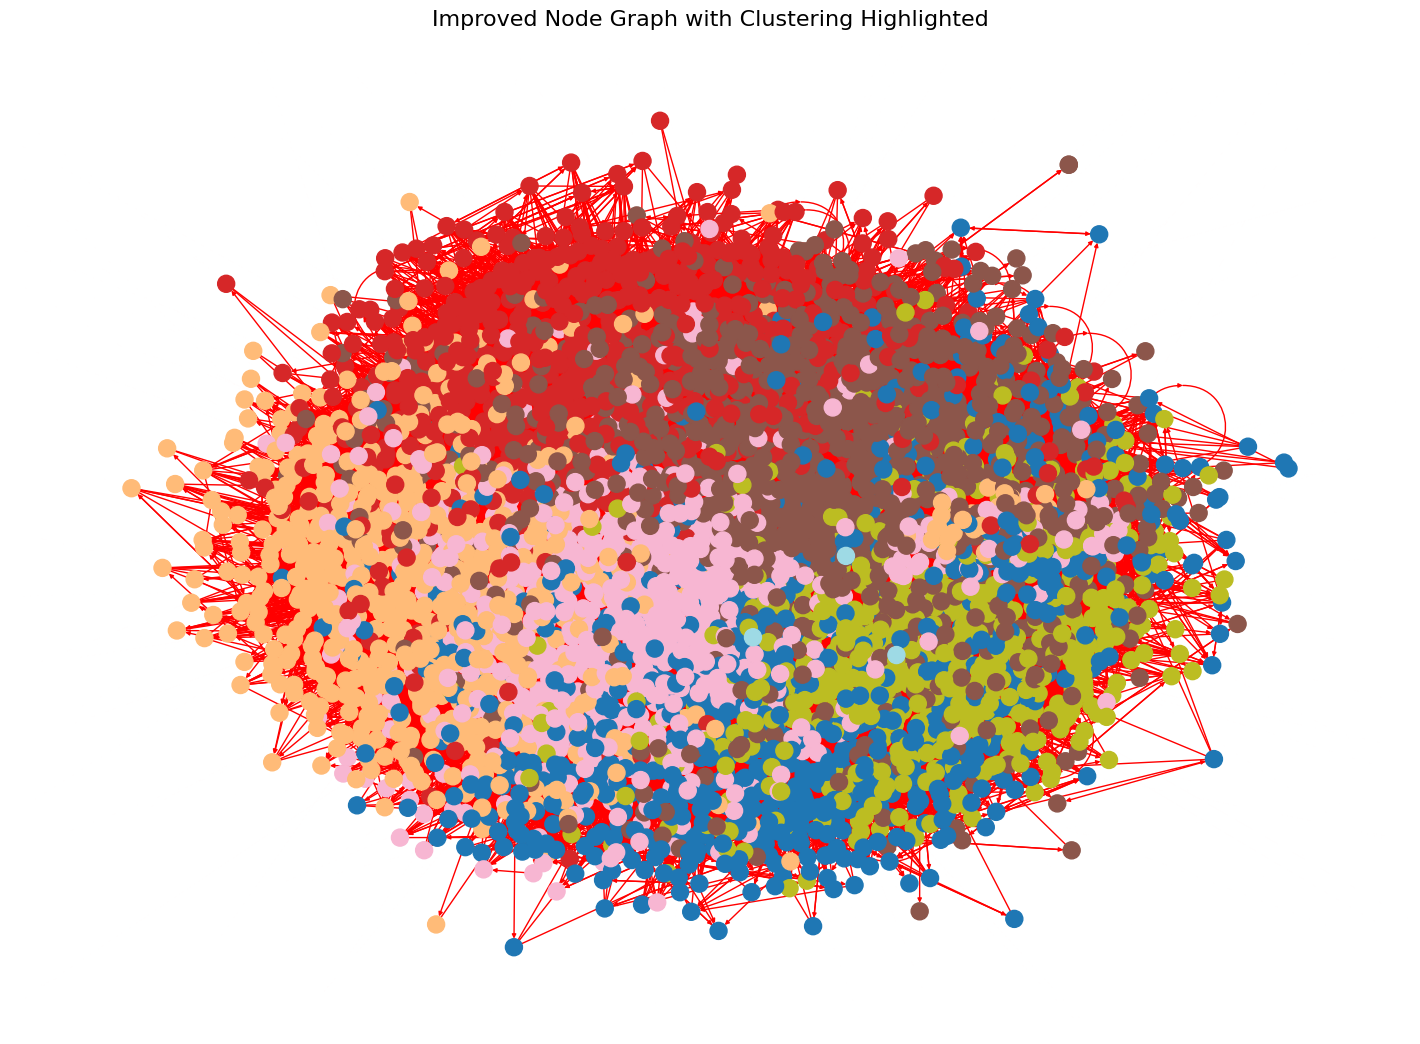

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain  # from the python-louvain package


#-----------------------------------------------------------
# 2. Create the graph from the DataFrame
#-----------------------------------------------------------
G = nx.DiGraph()

for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

# If community detection algorithms require undirected graphs:
G_undirected = G.to_undirected()

#-----------------------------------------------------------
# 3. Perform community detection (Louvain)
#    This partitions the graph into clusters represented by integers.
#-----------------------------------------------------------
partition = community_louvain.best_partition(G_undirected)

#-----------------------------------------------------------
# 4. Assign colors to each community
#   We'll use a categorical colormap to differentiate clusters.
#-----------------------------------------------------------
# Extract unique community IDs
community_ids = set(partition.values())
# Map each community to a color
# We'll use plt.cm.tab20 which gives up to 20 distinct colors,
# If you have more than 20 communities, consider another colormap or scheme.
color_map = {}
for i, c in enumerate(community_ids):
    color_map[c] = i  # index for color from the colormap

node_colors = [color_map[partition[node]] for node in G.nodes()]

#-----------------------------------------------------------
# 5. Choose a layout
#    For a dense graph, Kamada-Kawai or Fruchterman–Reingold might help.
#    Adjusting `k` in spring_layout might spread nodes further.
#-----------------------------------------------------------
# pos = nx.kamada_kawai_layout(G)   # Kamada-Kawai layout
# or use a force-directed layout with custom spacing:
#pos = nx.spring_layout(G, k=0.3, iterations=100)
pos = nx.kamada_kawai_layout(G)
#-----------------------------------------------------------
# 6. Draw the graph
#   - Node size and font size can be adjusted for clarity.
#   - with_labels can be set to False if too cluttered.
#-----------------------------------------------------------
plt.figure(figsize=(14,10))
nx.draw(
    G,
    pos,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    with_labels=False,
    node_size=150,
    font_size=8,
    font_weight="bold",
    arrowsize=6,
    edge_color="red"
)

plt.title("Improved Node Graph with Clustering Highlighted", fontsize=16)
plt.axis('off')
plt.show()

#-----------------------------------------------------------
# Additional Tweaks:
# - If the graph is still too cluttered, consider:
#   * Turning off all labels (with_labels=False) and using interactive tools.
#   * Drawing only a subset of edges or nodes.
#   * Highlighting communities by drawing polygons around clusters.
#-----------------------------------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain

# Assume you already have 'links' DataFrame and 'partition' from the previous steps
# links = pd.DataFrame({
#     'linkSource': [...],
#     'linkTarget': [...]
# })

G = nx.DiGraph()
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

G_undirected = G.to_undirected()

# Perform Louvain partitioning
partition = community_louvain.best_partition(G_undirected)

# Group nodes by community
from collections import defaultdict
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

# Check connectivity of each community
for comm_id, comm_nodes in communities.items():
    # Induced subgraph for this community
    subG = G_undirected.subgraph(comm_nodes)
    
    # Check if it's connected
    connected = nx.is_connected(subG)
    print(f"Community {comm_id}:")
    print(f"  Nodes in community: {len(comm_nodes)}")
    print(f"  Is connected? {connected}")
    print("--------------")

Community 0:
  Nodes in community: 855
  Is connected? True
--------------
Community 2:
  Nodes in community: 674
  Is connected? True
--------------
Community 4:
  Nodes in community: 813
  Is connected? True
--------------
Community 5:
  Nodes in community: 777
  Is connected? True
--------------
Community 6:
  Nodes in community: 633
  Is connected? True
--------------
Community 1:
  Nodes in community: 632
  Is connected? True
--------------
Community 3:
  Nodes in community: 116
  Is connected? True
--------------
Community 7:
  Nodes in community: 89
  Is connected? True
--------------
Community 8:
  Nodes in community: 3
  Is connected? True
--------------


In [7]:
# Extract the nodes from Community 2
comm_2_nodes = communities[2]

# Create the induced subgraph for Community 2
subG_2 = G_undirected.subgraph(comm_2_nodes)

# Get all connected components within this community
connected_components = list(nx.connected_components(subG_2))

print(f"Number of connected components in Community 2: {len(connected_components)}")

# Print size of each connected component
for i, comp in enumerate(connected_components):
    print(f"Component {i}: {len(comp)} nodes")

Number of connected components in Community 2: 1
Component 0: 674 nodes


In [8]:
# partition is a dict: node -> community_id

inter_cluster_edges = []
for (u, v) in G.edges():
    if partition[u] != partition[v]:
        inter_cluster_edges.append((u, v))

print(f"Number of inter-cluster edges: {len(inter_cluster_edges)}")
print("Some examples of edges connecting different communities:")
for edge in inter_cluster_edges[:10]:  # print first 10 for example
    print(edge, "connects", partition[edge[0]], "to", partition[edge[1]])


Number of inter-cluster edges: 53559
Some examples of edges connecting different communities:
('Áedán mac Gabráin', 'Monarchy') connects 0 to 2
('Bede', 'Hebrew language') connects 0 to 4
('Bede', 'Julius Caesar') connects 0 to 4
('Bede', 'Paul of Tarsus') connects 0 to 4
('Bede', 'Season') connects 0 to 1
('Bede', 'Virgil') connects 0 to 4
('Columba', 'Dove') connects 0 to 5
('Dál Riata', '8th century') connects 0 to 4
('Dál Riata', 'Barley') connects 0 to 4
('Dál Riata', 'Jewellery') connects 0 to 4


In [9]:
# Assuming 'G' is your directed graph and you've already built it
# from your links DataFrame

G_undirected = G.to_undirected()

# Find all connected components in the undirected version
components = list(nx.connected_components(G_undirected))

# Sort components by size (largest first)
components = sorted(components, key=len, reverse=True)

print(f"Number of connected components: {len(components)}")

# The first component is usually the largest one
main_component = components[0]
print(f"Size of the largest component: {len(main_component)}")

# Check if there are smaller components
if len(components) > 1:
    print("Found isolated subgroups (components) not connected to the main one:")
    for i, comp in enumerate(components[1:], start=2):
        print(f"Component {i}: {len(comp)} nodes")
        # You can inspect these nodes if you want
else:
    print("All nodes are in a single connected component, no isolated subgroups found.")


Number of connected components: 2
Size of the largest component: 4589
Found isolated subgroups (components) not connected to the main one:
Component 2: 3 nodes


In [10]:
# Use weakly connected components for a directed graph
components = list(nx.weakly_connected_components(G))

# Sort components by size (largest first)
components = sorted(components, key=len, reverse=True)

print(f"Number of weakly connected components: {len(components)}")

# The first component is usually the largest one
main_component = components[0]
print(f"Size of the largest component: {len(main_component)}")

# Check if there are smaller components
if len(components) > 1:
    print("Found isolated subgroups (weakly connected) not connected to the main one:")
    for i, comp in enumerate(components[1:], start=2):
        print(f"Component {i}: {len(comp)} nodes")
        # You can inspect these nodes if you want
else:
    print("All nodes are in a single weakly connected component, no isolated subgroups found.")


Number of weakly connected components: 2
Size of the largest component: 4589
Found isolated subgroups (weakly connected) not connected to the main one:
Component 2: 3 nodes


In [11]:
# After obtaining the components as above:
components = list(nx.connected_components(G_undirected))
components = sorted(components, key=len, reverse=True)

main_component = components[0]
isolated_component = components[1]

print("Nodes in the isolated component:", isolated_component)


Nodes in the isolated component: {'Directdebit', 'Friend Directdebit', 'Sponsorship Directdebit'}


In [12]:
import networkx as nx

# Suppose G is your directed graph
one_way_edges = []
two_way_edges = []

for u, v in G.edges():
    # Check if the reverse edge also exists
    if G.has_edge(v, u):
        # This edge pair is bidirectional
        two_way_edges.append((u, v))
    else:
        # This edge is only one-way
        one_way_edges.append((u, v))
        
print(f"One-way edges: {len(one_way_edges)}")
print(f"Two-way edges: {len(two_way_edges)}")


One-way edges: 93302
Two-way edges: 26580


In [13]:
article_similarities = pd.read_csv('data/article_similarities_matrix.csv')

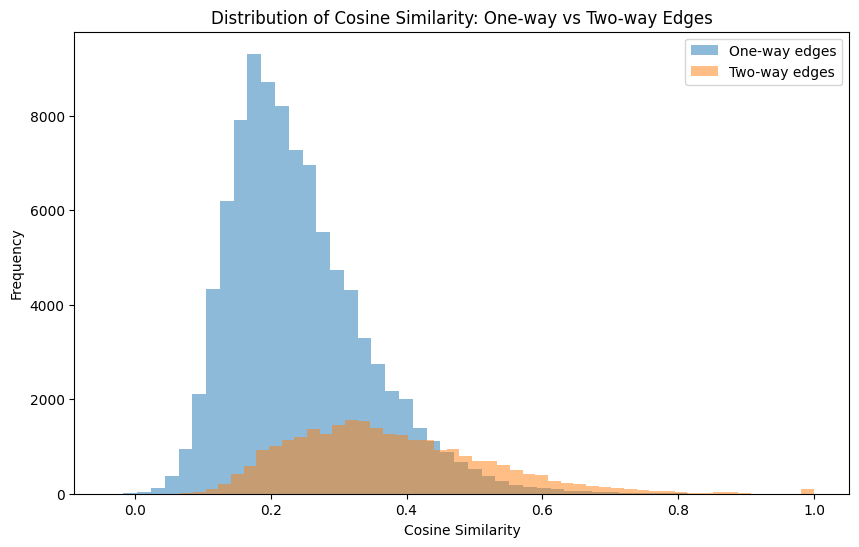

One-way edges statistics:
Mean distance: 0.240
Median distance: 0.223
Std deviation: 0.100

Two-way edges statistics:
Mean distance: 0.374
Median distance: 0.353
Std deviation: 0.144


In [14]:
# Get one-way and two-way edges
one_way_edges = []
two_way_edges = []

for u, v in G.edges():
    # Check if the reverse edge exists
    if G.has_edge(v, u):
        # This edge pair is bidirectional
        two_way_edges.append((u, v))
    else:
        # This edge is only one-way
        one_way_edges.append((u, v))

# Calculate semantic distances for both types of edges
one_way_distances = []
two_way_distances = []

for u, v in one_way_edges:
    # Get indices for the distance matrix
    u_idx = articles[articles['article'] == u].index[0]
    v_idx = articles[articles['article'] == v].index[0]
    one_way_distances.append(article_similarities.iloc[u_idx, v_idx])


for u, v in two_way_edges:
    u_idx = articles[articles['article'] == u].index[0]
    v_idx = articles[articles['article'] == v].index[0]
    two_way_distances.append(article_similarities.iloc[u_idx, v_idx])

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(one_way_distances, alpha=0.5, label='One-way edges', bins=50)
plt.hist(two_way_distances, alpha=0.5, label='Two-way edges', bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity: One-way vs Two-way Edges')
plt.legend()
plt.show()

# Print some statistics
print(f"One-way edges statistics:")
print(f"Mean distance: {np.mean(one_way_distances):.3f}")
print(f"Median distance: {np.median(one_way_distances):.3f}")
print(f"Std deviation: {np.std(one_way_distances):.3f}")
print("\nTwo-way edges statistics:")
print(f"Mean distance: {np.mean(two_way_distances):.3f}")
print(f"Median distance: {np.median(two_way_distances):.3f}")
print(f"Std deviation: {np.std(two_way_distances):.3f}")

In [15]:
print(one_way_edges)

[('Áedán mac Gabráin', 'Bede'), ('Áedán mac Gabráin', 'Columba'), ('Áedán mac Gabráin', 'Dál Riata'), ('Áedán mac Gabráin', 'Great Britain'), ('Áedán mac Gabráin', 'Ireland'), ('Áedán mac Gabráin', 'Isle of Man'), ('Áedán mac Gabráin', 'Monarchy'), ('Áedán mac Gabráin', 'Orkney'), ('Áedán mac Gabráin', 'Picts'), ('Áedán mac Gabráin', 'Scotland'), ('Áedán mac Gabráin', 'Wales'), ('Bede', 'Abbot'), ('Bede', 'Dante Alighieri'), ('Bede', 'Durham Cathedral'), ('Bede', 'Great Britain'), ('Bede', 'Hebrew language'), ('Bede', 'Julius Caesar'), ('Bede', 'Middle Ages'), ('Bede', 'Music'), ('Bede', 'Season'), ('Bede', 'Virgil'), ('Columba', 'Christianity'), ('Columba', 'Dark Ages'), ('Columba', 'Dove'), ('Columba', 'Hebrides'), ('Columba', 'Ireland'), ('Columba', 'King Arthur'), ('Columba', 'Roman Catholic Church'), ('Dál Riata', '8th century'), ('Dál Riata', 'Barley'), ('Dál Riata', 'Bede'), ('Dál Riata', 'Book of Kells'), ('Dál Riata', 'Elizabeth II of the United Kingdom'), ('Dál Riata', 'Great

In [16]:
import urllib.parse
from tqdm import tqdm

link_article_name_present = []
link_article_absent = []

# Get frequent pairs from one-way edges
one_way_edges_df = pd.DataFrame(one_way_edges, columns=['source', 'target'])

for _, row in tqdm(one_way_edges_df.iterrows()):
    target= row['source']
    source= row['target']
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()
    if target.lower() in source_article_lowered:
        link_article_name_present.append((target,source))
    else:
        link_article_absent.append((target,source))

93302it [00:13, 6843.71it/s]


In [17]:
print(len(link_article_name_present))
print(len(link_article_absent))

7795
85507


In [18]:
G = nx.DiGraph()
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

G_copy = G.copy()
new_copy=G.copy()

In [19]:
# Add reverse links for cases where the article name is present
for source, target in link_article_name_present:
    # Add the reverse edge to the graph
    G.add_edge(target, source)
    G.add_edge(source, target)

In [20]:
#SIMILARITY_THRESHOLD = 0.374  # Can be adjusted based on needs
SIMILARITY_THRESHOLD = 0.3
# Process one-way edges that weren't already added
remaining_one_way = [(source, target) for source, target in one_way_edges 
                     if (target, source) not in link_article_name_present]

for source, target in tqdm(remaining_one_way):
    u_idx = articles[articles['article'] == source].index[0]
    v_idx = articles[articles['article'] == target].index[0]
    try:
        # If similarity is above threshold, add bidirectional edge
        similarity = article_similarities.loc[u_idx, v_idx]
        if similarity >= SIMILARITY_THRESHOLD:
            G_copy.add_edge(target, source)
            G_copy.add_edge(source, target)
    except:
        continue  # Skip if there are any file reading issues


100%|██████████| 93302/93302 [00:33<00:00, 2799.87it/s]


In [21]:
def draw_condensed_graph(G):
    # Find strongly connected components
    strongly_connected = list(nx.strongly_connected_components(G))
    
    # Find the largest component
    largest_component = max(range(len(strongly_connected)), key=lambda x: len(strongly_connected[x]))

    # Filter components and identify isolated components
    filtered_components = []
    isolated_nodes_in = set()  # Nodes with only incoming edges to main component
    isolated_nodes_out = set() # Nodes with only outgoing edges from main component

    for i, comp in enumerate(strongly_connected):
        if len(comp) > 1:
            filtered_components.append(comp)
        elif i != largest_component:  # Size 1 component that's not the largest
            # Check direction of connections with largest component
            has_incoming = False
            has_outgoing = False
            for node in comp:
                for main_node in strongly_connected[largest_component]:
                    if G.has_edge(node, main_node):
                        has_outgoing = True
                    if G.has_edge(main_node, node):
                        has_incoming = True
            
            if has_incoming and not has_outgoing:
                isolated_nodes_in.update(comp)
            elif has_outgoing and not has_incoming:
                isolated_nodes_out.update(comp)
            else:
                filtered_components.append(comp)

    # Add isolated nodes as separate components
    if isolated_nodes_in:
        filtered_components.append(isolated_nodes_in)
    if isolated_nodes_out:
        filtered_components.append(isolated_nodes_out)

    # Create a new graph of filtered strongly connected components
    scc_graph = nx.DiGraph()
    for i in range(len(filtered_components)):
        scc_graph.add_node(i)

    # Add edges between components
    for i, comp1 in enumerate(filtered_components):
        for j, comp2 in enumerate(filtered_components):
            if i != j:
                if any(G.has_edge(u, v) for u in comp1 for v in comp2):
                    scc_graph.add_edge(i, j)

    # Draw the condensed graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(scc_graph, k=2, iterations=50)
    pos = {node: (coords[0]*1.5, coords[1]*1.5) for node, coords in pos.items()}

    # Prepare node colors and sizes
    node_colors = []
    node_sizes = []
    labels = {}
    for n in scc_graph.nodes():
        if filtered_components[n] == isolated_nodes_in:
            node_colors.append('red')
            node_sizes.append(len(filtered_components[n]))
            labels[n] = f"incoming isolated\n(size: {len(filtered_components[n])})"
        elif filtered_components[n] == isolated_nodes_out:
            node_colors.append('orange')
            node_sizes.append(len(filtered_components[n]))
            labels[n] = f"outgoing isolated\n(size: {len(filtered_components[n])})"
        else:
            node_colors.append('lightgreen' if len(filtered_components[n]) > 1 else 'lightblue')
            node_sizes.append(len(filtered_components[n]) if len(filtered_components[n]) > 1000 else 100*len(filtered_components[n]))
            labels[n] = str(len(filtered_components[n]))

    nx.draw(scc_graph, pos,
            node_color=node_colors,
            node_size=node_sizes,
            with_labels=False,
            arrows=True,
            edge_color='gray',
            alpha=0.7)

    nx.draw_networkx_labels(scc_graph, pos, labels, font_size=8)

    plt.title("Condensed Graph of Strongly Connected Components")
    plt.show()
    # Save the largest component nodes to a text file
    with open(f'largest_component.txt', 'w') as f:
        for node in strongly_connected[largest_component]:
            f.write(f"{node}\n")

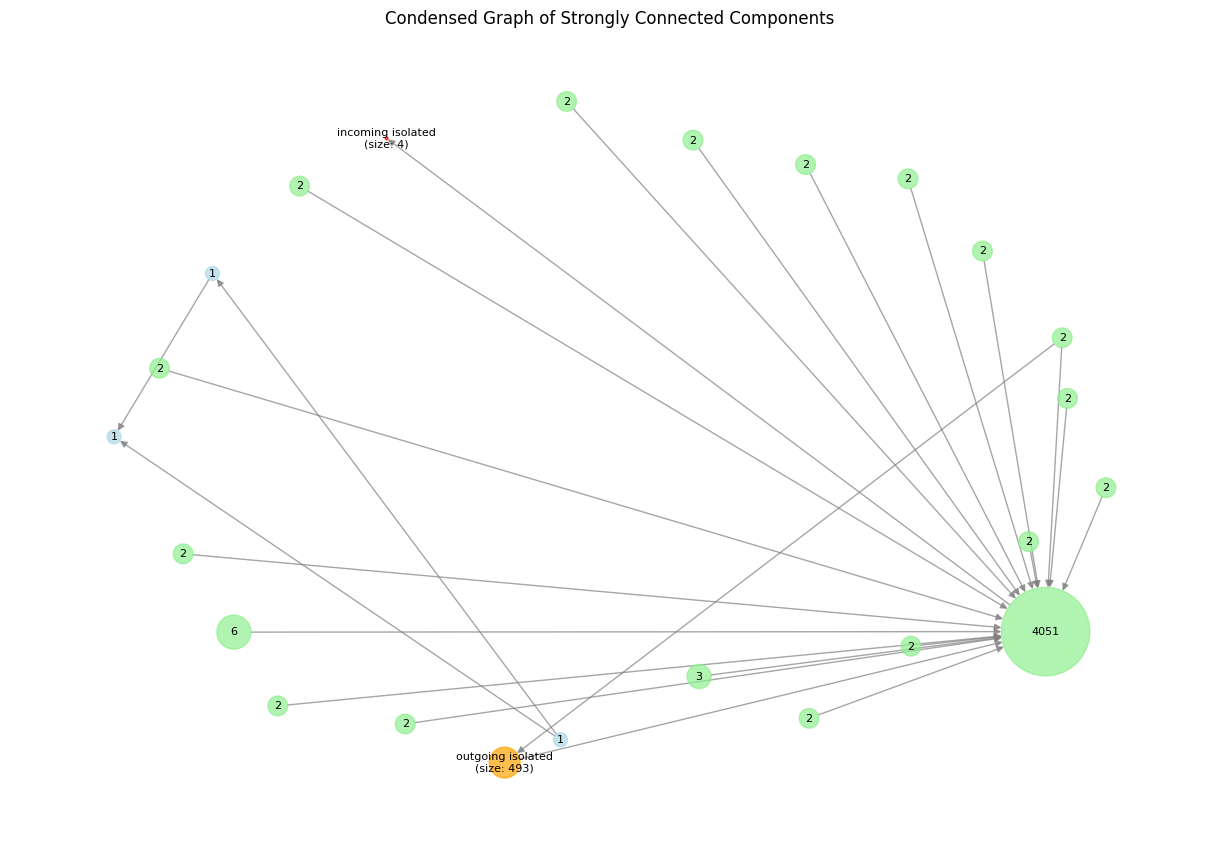

In [22]:
draw_condensed_graph(new_copy)

In [23]:
def draw_isolated_groups(G):
    # Get strongly connected components
    sccs = list(nx.strongly_connected_components(G))
    
    # Find isolated incoming and outgoing components
    isolated_in = set()
    isolated_out = set()
    
    for component in sccs:
        if len(component) == 1:
            node = list(component)[0]
            in_edges = G.in_edges(node)
            out_edges = G.out_edges(node) 
            
            if len(in_edges) > 0 and len(out_edges) == 0:
                isolated_out.add(node)
            elif len(in_edges) == 0 and len(out_edges) > 0:
                isolated_in.add(node)
    
    # Create subgraph of isolated nodes and their connections
    isolated_nodes = isolated_in.union(isolated_out)
    subgraph = G.subgraph(isolated_nodes)
    
    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph)
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, 
                          nodelist=list(isolated_in),
                          node_color='red',
                          node_size=100,
                          label='Isolated Incoming')
    
    nx.draw_networkx_nodes(subgraph, pos,
                          nodelist=list(isolated_out), 
                          node_color='orange',
                          node_size=100,
                          label='Isolated Outgoing')
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True)
    
    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    
    plt.title("Graph of Isolated Incoming and Outgoing Nodes")
    plt.legend()
    plt.show()
    return isolated_in, isolated_out 

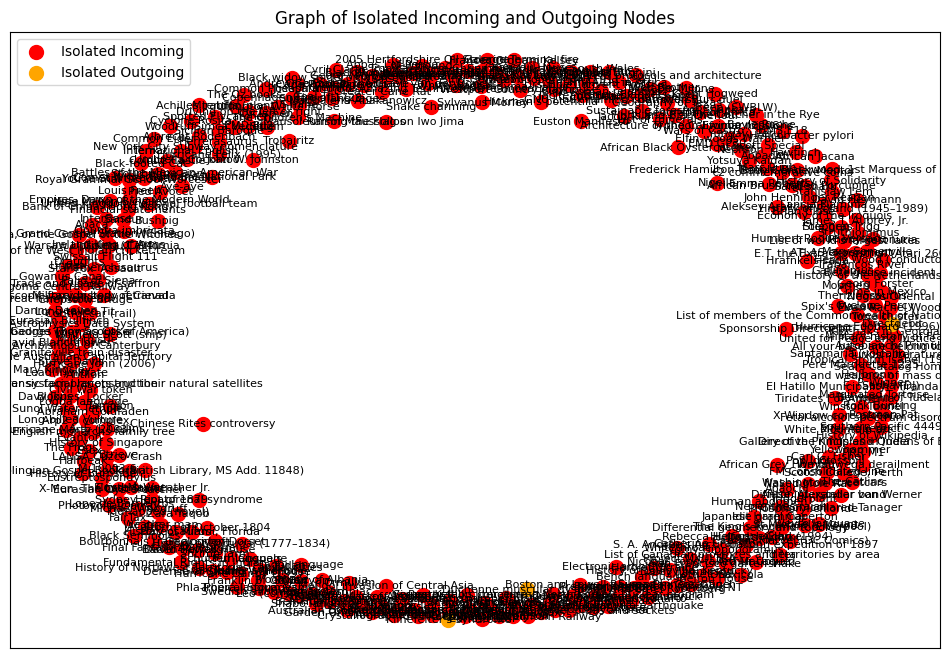

{'2005 Hertfordshire Oil Storage Terminal fire',
 '2005 Lake Tanganyika earthquake',
 'A Wrinkle in Time',
 'A. E. J. Collins',
 'AC DC',
 'ATLAS experiment',
 'Abacá',
 'Abbadid',
 'Abbas I of Persia',
 'Abraham Goldfaden',
 'Achilles tendon',
 'Actuary',
 'Adi Shankara',
 'Adriaen van der Donck',
 'African Black Oystercatcher',
 'African Brush-tailed Porcupine',
 'African Grey Hornbill',
 'African Jacana',
 'Albrecht Rodenbach',
 'Aleksey Arakcheyev',
 'Algoma Central Railway',
 'All your base are belong to us',
 'Amda Seyon I',
 'Andrew Gonzalez',
 'Annibale Bugnini',
 'Antlion',
 'Anton Alexander von Werner',
 'Apaochi',
 'Aradia, or the Gospel of the Witches',
 'Architecture of Windows NT',
 'Architecture of the California missions',
 'Arp2 3 complex',
 'Arthur Upfield',
 'Astrophysics Data System',
 'Australian Ringneck',
 'Australian constitutional law',
 'Autobianchi Primula',
 'Automatic number plate recognition',
 'Aye-aye',
 'Baby Gender Mentor',
 'Baden-Powell House',
 'Ban

In [24]:
isolated_in, isolated_out = draw_isolated_groups(G)
isolated_in


In [25]:
isolated_out

{'Directdebit', 'Duchenne muscular dystrophy', "Klinefelter's syndrome"}

In [26]:
# Save isolated nodes to files
with open('isolated_out.txt', 'w') as f:
    for node in isolated_out:
        f.write(f"{node}\n")
        
with open('isolated_in.txt', 'w') as f:
    for node in isolated_in:
        f.write(f"{node}\n")


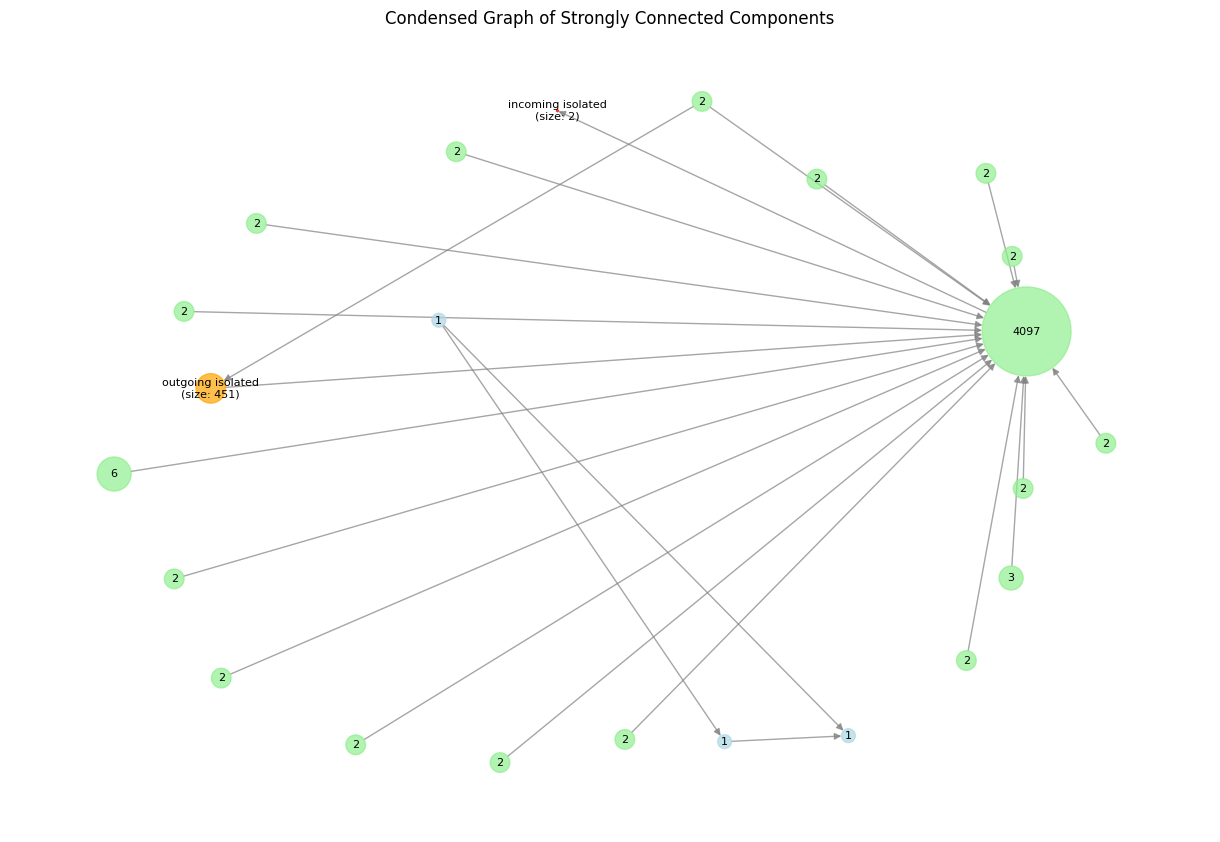

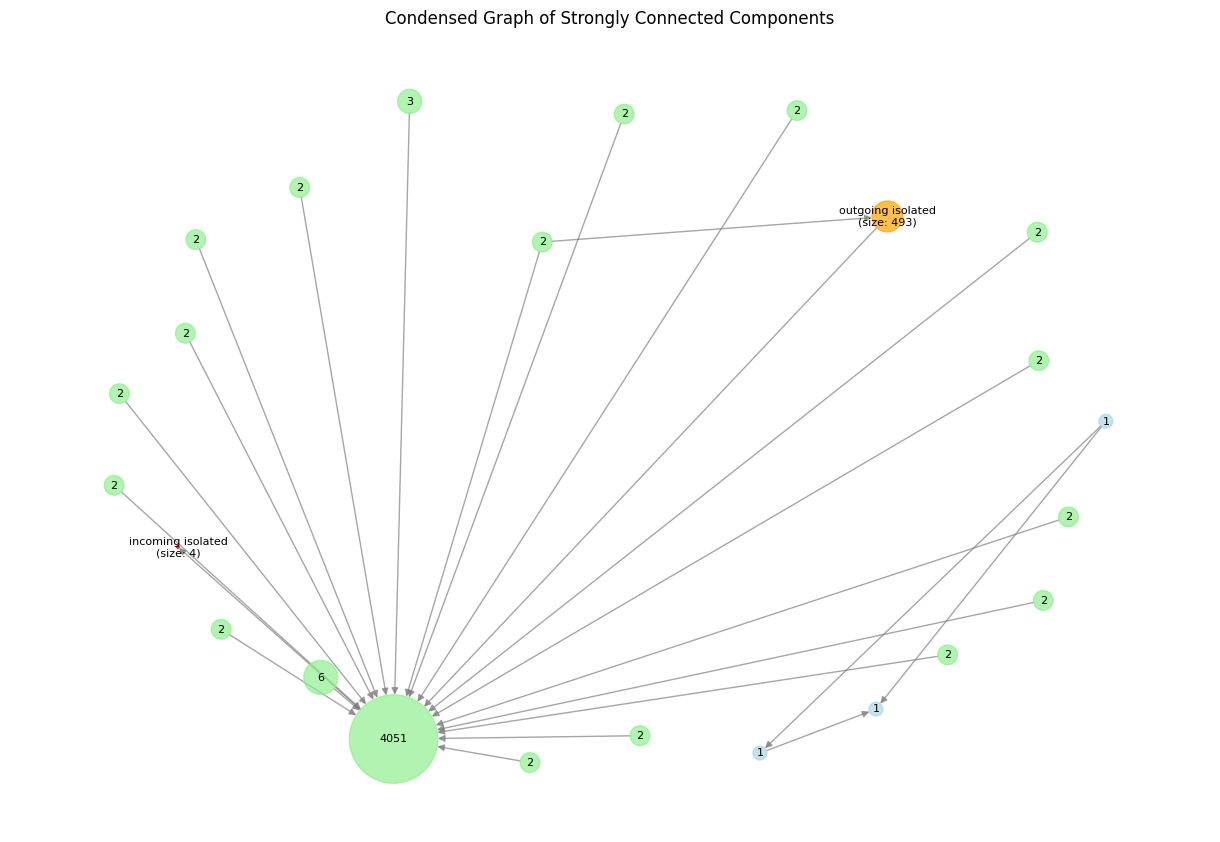

In [27]:
draw_condensed_graph(G)
draw_condensed_graph(G_copy)

In [28]:
articles.size-4588-4

12

In [29]:
# Strongly connected components:
sccs = list(nx.strongly_connected_components(G))
print(f"Number of strongly connected components: {len(sccs)}")

Number of strongly connected components: 474


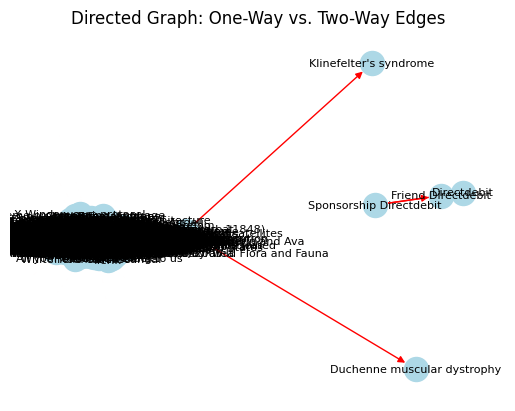

In [30]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="lightblue")
nx.draw_networkx_labels(G, pos, font_size=8)

# Draw one-way edges in red
nx.draw_networkx_edges(G, pos, edgelist=one_way_edges, edge_color="red", arrows=True)

# Draw two-way edges in green for clarity
#nx.draw_networkx_edges(G, pos, edgelist=two_way_edges, edge_color="green", arrows=True)

plt.title("Directed Graph: One-Way vs. Two-Way Edges")
plt.axis("off")
plt.show()


In [31]:
# Strongly connected components:
sccs = list(nx.strongly_connected_components(G))
print(f"Number of strongly connected components: {len(sccs)}")

Number of strongly connected components: 474


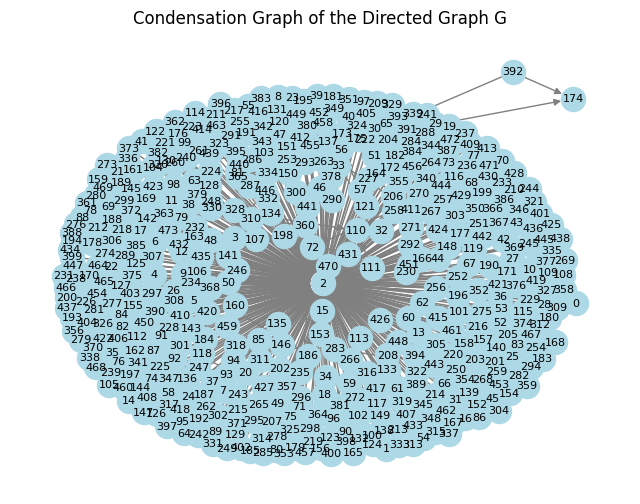

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose G is your directed graph
# Compute strongly connected components and the condensation graph
condensation = nx.condensation(G)

# Compute a layout for the condensation graph
pos_cond = nx.spring_layout(condensation, k=0.3)

# Draw the condensation graph
plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(condensation, pos_cond, node_size=300, node_color="lightblue")
nx.draw_networkx_labels(condensation, pos_cond, font_size=8)
nx.draw_networkx_edges(condensation, pos_cond, edge_color="gray", arrows=True)

plt.title("Condensation Graph of the Directed Graph G")
plt.axis("off")
plt.show()


In [33]:
start_node = "Bob Dylan"
reachable_nodes = nx.descendants(G, start_node)
reachable_nodes.add(start_node)
isolated_from_start = set(G.nodes()) - reachable_nodes

print(f"From {start_node}\n these nodes are reachable: {reachable_nodes} \n these nodes are not reachable: {isolated_from_start}")

From Bob Dylan
 these nodes are reachable: {'Athens', 'Liquid crystal', '13th century', 'Graphic novel', 'Dresden', 'Tropical Storm Franklin (2005)', 'Ordinary differential equation', 'Maseru', 'Netball', 'Oil refinery', 'Gypsum', 'Battle of Midway', 'Logistics', 'Ichthyosaur', 'Australian English', 'Social contract (Malaysia)', 'Rupee', 'RMS Titanic', 'Antimony', 'York', 'Anguilla', 'Celtic mythology', 'Pinworm', 'Brussels', 'John Seigenthaler, Sr.', 'Californium', 'Soybean', 'Technetium', 'Great Red Spot', 'Chicago', 'Isle of Man', 'Whale', 'Lake Vostok', 'Pakistan', 'Universe', 'Varanasi', 'Puerto Rico', 'New York City', 'Monrovia', 'Matrix (mathematics)', 'Numismatics', 'Johannesburg', 'Nazi Germany', 'Nicolaus Copernicus', 'Ukulele', 'Albrecht Dürer', 'Björn Borg', 'Electric field', 'Retreat of glaciers since 1850', 'Thalassemia', 'Bog', 'Dakota, Minnesota and Eastern Railroad', 'Makuria', 'Antoine Lavoisier', 'Boolean logic', 'Nintendo Entertainment System', 'Ubuntu (Linux distri

KeyError: 'Bob_Dylan'

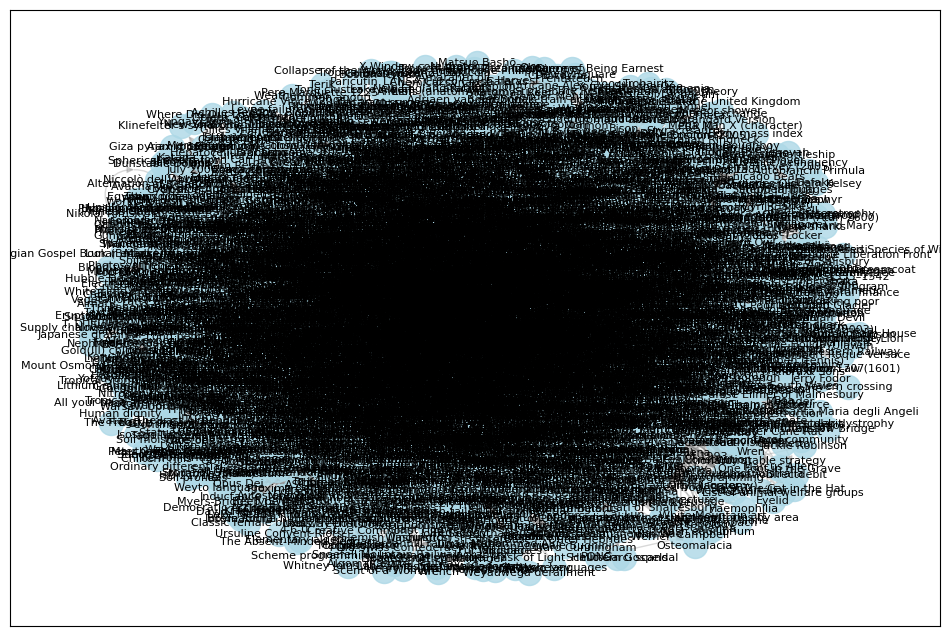

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Example placeholders:
# G: your main graph of articles
# finished_paths: list of lists, each is a path of nodes ending at target_node
# unfinished_paths: list of lists, each is a path of nodes not ending at target_node
# target_node: the target article node (e.g. "Christmas")
# semantic_similarity(u, v): function that returns the cosine similarity between nodes u and v

# Dummy placeholders for demonstration purposes:
Graph  = nx.DiGraph()
# Add some edges (you would replace this with your full network)
Graph.add_edges_from([
    ("Bob_Dylan", "Winter"), ("Winter", "Snow"), ("Snow", "Santa_Claus"),
    ("Santa_Claus", "Domesticated_Turkey"), ("Domesticated_Turkey", "Roman_Britain"),
    ("Roman_Britain", "Christmas"),  # imagine this eventually leads to the target
    # Unconnected "island"
    ("Soybean", "Agriculture"), ("Agriculture", "Food"),
    # Suppose "Bean" doesn't exist or is not linked
])

finished_paths = [
    ["Bob_Dylan", "Winter", "Snow", "Santa_Claus", "Roman_Britain", "Christmas"]
]

unfinished_paths = [
    ["Soybean", "Agriculture", "Food"]  # never reaches "Christmas"
]

target_node = "Christmas"

def semantic_similarity(u, v):
    # Placeholder: In reality, you'd load precomputed embeddings and compute or look up cosine similarity.
    # Here, we just return a random or fixed value for demonstration.
    # Assume "Soybean" and "Bean" would have a high similarity if "Bean" existed.
    # Let's just return a high similarity for certain pairs to simulate missing link scenario.
    if (u == "Soybean" and v == "Bean") or (u == "Bean" and v == "Soybean"):
        return 0.9
    return 0.2

# 1. Compute a layout
pos = nx.spring_layout(G, k=0.3)

# 2. Extract edges from finished and unfinished paths
def path_to_edges(path):
    return list(zip(path[:-1], path[1:]))

finished_edges = set()
for p in finished_paths:
    finished_edges.update(path_to_edges(p))

unfinished_edges = set()
for p in unfinished_paths:
    unfinished_edges.update(path_to_edges(p))

# 3. Draw the base graph edges lightly
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray", alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

# 4. Overlay finished and unfinished edges
nx.draw_networkx_edges(
    G, pos, edgelist=finished_edges,
    edge_color="green", width=2.0,
    label="Finished Paths"
)
nx.draw_networkx_edges(
    G, pos, edgelist=unfinished_edges,
    edge_color="red", width=2.0, style="dashed",
    label="Unfinished Paths"
)

# 5. Identify “semantic islands”: nodes semantically close to target but no direct link
#    Check nodes that don't have a direct link to target_node but have high similarity.
threshold = 0.5  # adjustable threshold
islands = []
for node in G.nodes():
    if node != target_node:
        sim = semantic_similarity(node, target_node)
        # Check if not directly connected to target_node:
        if not G.has_edge(node, target_node) and not G.has_edge(target_node, node):
            if sim >= threshold:
                islands.append(node)

# 6. Highlight these "unreachable semantic islands"
#    For instance, draw them with a different shape (triangle) or a red border
nx.draw_networkx_nodes(
    G, pos, nodelist=islands,
    node_shape='^', node_color='yellow', edgecolors='red', linewidths=2.0,
    label="Semantic Islands (no direct link)"
)

# Add legend
plt.legend(scatterpoints=1)
plt.title("Finished vs. Unfinished Paths with Semantic Islands")
plt.axis('off')
plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


# Create a graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

In [ ]:
# Re-rendering the graph with improved separation using `kamada_kawai_layout`
plt.figure(figsize=(14, 10))

# Use Kamada-Kawai layout for better spacing
pos = nx.kamada_kawai_layout(G)

# Draw the graph with adjusted parameters for readability
nx.draw(
    G, 
    pos, 
    with_labels=True, 
    node_size=1500, 
    node_color="lightblue", 
    font_size=8, 
    font_weight="bold", 
    arrowsize=10,
    edge_color="gray"
)

plt.title("Improved Node Graph with Kamada-Kawai Layout", fontsize=14)
plt.show()


In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# Detect clusters using the greedy modularity algorithm
clusters = list(greedy_modularity_communities(G))

# Assign a unique color to each cluster
cluster_colors = itertools.cycle(['lightblue', 'lightgreen', 'salmon', 'orange', 'purple', 'cyan'])
node_colors = {}

for cluster, color in zip(clusters, cluster_colors):
    for node in cluster:
        node_colors[node] = color

# Apply the colors to the nodes in the graph
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G)

# Draw the graph with cluster colors
nx.draw(
    G, 
    pos, 
    with_labels=True, 
    node_size=1500, 
    node_color=[node_colors[node] for node in G.nodes], 
    font_size=8, 
    font_weight="bold", 
    arrowsize=10,
    edge_color="gray"
)

plt.title("Node Graph with Highlighted Clusters", fontsize=14)
plt.show()

In [ ]:
# Get pairs where there is no link (original -1 values now 1 in normalized matrix)
no_link_pairs = np.argwhere(distance_matrix == -1)
# Matching no_link_pairs with article names
matched_pairs = [(articles.iloc[pair[0]]['article'], articles.iloc[pair[1]]['article']) for pair in no_link_pairs]

In [ ]:
# Display matched pairs
matched_pairs

In [ ]:
matched_pairs_df = pd.DataFrame(matched_pairs, columns=['Source', 'Target'])

# Extract unique sources from the Source column of matched_pairs_df
new_list = matched_pairs_df['Source'].unique().tolist()

# Filter the links DataFrame to find links between nodes in new_list
filtered_links = links[
    (links['linkSource'].isin(new_list)) & (links['linkTarget'].isin(new_list))
]

# Create a graph with the filtered links
G = nx.DiGraph()

for _, row in filtered_links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])

# Visualize the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrowsize=15,
    edge_color="black"
)

plt.title("Graph of Links Between Matched Pairs", fontsize=14)

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# Detect clusters using the greedy modularity algorithm
clusters = list(greedy_modularity_communities(G))

# Assign a unique color to each cluster
cluster_colors = itertools.cycle(['lightblue', 'lightgreen', 'salmon', 'orange', 'purple', 'cyan'])
node_colors = {}

for cluster, color in zip(clusters, cluster_colors):
    for node in cluster:
        node_colors[node] = color

# Apply the colors to the nodes in the graph
plt.figure(figsize=(14, 10))
pos = nx.kamada_kawai_layout(G)

# Draw the graph with cluster colors
nx.draw(
    G, 
    pos, 
    with_labels=True, 
    node_size=1500, 
    node_color=[node_colors[node] for node in G.nodes], 
    font_size=8, 
    font_weight="bold", 
    arrowsize=10,
    edge_color="gray"
)

plt.title("Node Graph with Highlighted Clusters", fontsize=14)
plt.show()

In [ ]:
all_paths.head()

---

## Heatmap Fun

In [ ]:
# Replace -1 values with np.nan to ignore them during normalization
distance_matrix_normalized = np.where(distance_matrix == -1, np.nan, distance_matrix)

# Perform normalization on the matrix, excluding NaN values
min_value = np.nanmin(distance_matrix_normalized)
max_value = np.nanmax(distance_matrix_normalized)
distance_matrix_normalized = (distance_matrix_normalized - min_value) / (max_value - min_value)

# Replace NaNs (original -1 values) with 1
distance_matrix_normalized = np.where(np.isnan(distance_matrix_normalized), 1, distance_matrix_normalized)

distance_matrix_normalized

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix_normalized, cmap="YlGnBu", annot=False, cbar=True)
plt.title('Heatmap of Normalized Distance Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


In [ ]:
article_similarities = pd.read_csv('data/article_similarities_matrix.csv')

In [ ]:
flattened_similarities = article_similarities.values.flatten()


plt.axvline(x=0.3, color = "red")
plt.hist(flattened_similarities, bins=50, alpha=0.7)
plt.title('Original Data Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


In [ ]:
total_elements = flattened_similarities.size
print(f"Total number of elements: {total_elements}")

In [ ]:
count = (flattened_similarities > 0.3).sum()-articles.size #minus the number of article which are obviously related to themself
print(f"Number of values greater than 0.3: {count}")
print(f"Top percentage: {count*100/total_elements}")

In [ ]:
# Define a threshold value
threshold = 0.3

# Apply the threshold to the similarity matrix
thresholded_similarities = article_similarities.copy()
thresholded_similarities[thresholded_similarities < threshold] = np.nan  # Mask values below the threshold

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(thresholded_similarities, cmap="YlGnBu", annot=False, cbar=True, mask=np.isnan(thresholded_similarities))
plt.title(f'Heatmap of Article Similarities (Threshold: >{threshold})')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


In [ ]:
distance_diff = distance_matrix_normalized - np.abs(1-article_similarities) 

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_diff, cmap="YlGnBu", annot=False, cbar=True)
plt.title(f'Difference between Article similarities and Semantic Distance')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

---

## Category Analysis

In [ ]:
categories = data_loader.load_categories()


In [ ]:
# Remove leading/trailing dots from the category column
categories['cleaned_category'] = categories['category'].str.strip('.')

# Replace dots with spaces for better readability
categories['cleaned_category'] = categories['cleaned_category'].str.replace('.', ' ', regex=False)

# Remove the word "subject"
categories['cleaned_category'] = categories['cleaned_category'].str.replace(r'\bsubject\b', '', regex=True).str.strip()

# Extract the main theme (first word) and create a new column
categories['main_theme'] = categories['cleaned_category'].apply(lambda x: x.split(' ')[0])

# Group by main theme and count occurrences
categories_grouped = categories.groupby('main_theme')['cleaned_category'].apply(list)
category_counts = categories['main_theme'].value_counts()

# Display results
print("Counts by main theme:")
print(category_counts)

print("\nCategories grouped by main theme:")
print(categories_grouped)


In [ ]:
categories.head()

In [ ]:
categories.groupby('main_theme')['main_theme'].count()

In [ ]:
main_cat_dict = dict(zip(categories['article'], categories['cleaned_category']))

In [ ]:
main_cat_dict.get("Sunlight")

In [ ]:
all_backtracks = all_paths['backtracks'].dropna()

all_backtracks = all_backtracks.astype(str).str.replace(r"[\[\]]", "", regex=True).str.split(';')

# Flatten the cleaned list of lists
flattened_backtracks = [item.strip() for sublist in all_backtracks for item in sublist]

# Print the cleaned results
print(flattened_backtracks)

In [ ]:
from collections import defaultdict
from src.utils.utils import url_decode
import re

# Initialize a dictionary to count backtracks per category
backtrack_counts = defaultdict(int)

# Clean the flattened backtracks to remove square brackets and split correctly
cleaned_backtracks = []
for word in flattened_backtracks:
    if isinstance(word, str):
        # Remove square brackets if they exist and split on commas
        words = re.sub(r"\[.*?\]", "", word).split(',')
        # Add cleaned words to the list
        cleaned_backtracks.extend([w.strip() for w in words if w.strip()])

# Iterate over cleaned backtracks and count backtracks for each category
for word in cleaned_backtracks:
    # Decode the word (if necessary)
    decoded_word = url_decode(word)
    
    # Get the category of the word from the main_cat_dict
    backtrack_cat = main_cat_dict.get(decoded_word)
    
    # Debugging: print the category
    print(f"Word: {word}, Decoded: {decoded_word}, Category: {backtrack_cat}")
    
    # If the category exists, increment its count
    if backtrack_cat:
        backtrack_counts[backtrack_cat] += 1

# Convert defaultdict to a regular dictionary for easier manipulation
backtrack_counts = dict(backtrack_counts)

# Display the counts
for category, count in backtrack_counts.items():
    print(f"Category: {category}, Backtrack Count: {count}")


---

## Test random de clustering Hugo

In [ ]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()
embedding = pd.read_csv('data/embeddings.csv')
embedding['article'] = embedding['article'].apply(url_decode)

In [ ]:
all_words = [word for sublist in all_paths['backtracks'] if sublist for word in sublist]
backtrack_words = set(all_words)
embedding_dict = dict(zip(embedding['article'], embedding['embedding']))
# Create a DataFrame for the backtrack words
backtrack_df = pd.DataFrame({'backtrack_word': list(backtrack_words)})

# Step 1: Flatten all backtracks into a single list
all_words = [word for sublist in all_paths['backtracks'] if sublist for word in sublist]

# Step 2: Count occurrences of each word
word_counts = pd.Series(all_words).value_counts()

# Step 3: Create a DataFrame with backtrack words and their counts
backtrack_words_df = pd.DataFrame({
    'backtrack_word': word_counts.index,
    'count': word_counts.values
})

# Step 4: Merge with the original DataFrame to add the count column
backtrack_df = backtrack_df.merge(backtrack_words_df, on='backtrack_word', how='left')


# Map the encoded versions using the embedding dictionary
backtrack_df['encoded_version'] = backtrack_df['backtrack_word'].map(embedding_dict)

# Display the first few rows of the resulting DataFrame
print(backtrack_df.head())

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 0: Extract embeddings from the DataFrame
backtrack_df['encoded_version'] = backtrack_df['encoded_version'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter out rows where 'encoded_version' is still invalid (e.g., not arrays)
backtrack_df = backtrack_df.dropna(subset=['encoded_version'])

# Convert the embeddings column to a 2D NumPy array
embeddings = np.vstack(backtrack_df['encoded_version'].values)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# Step 1: Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Step 2: Fit GMM
n_components = 15  # Adjust the number of components (clusters)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(embeddings)

# Step 3: Extract soft cluster probabilities (responsibilities)
responsibilities = gmm.predict_proba(embeddings)

backtrack_df['gmm_cluster'] = gmm.predict(embeddings)

# Step 4: Visualize the probabilities for each cluster
for cluster_idx in range(n_components):
    plt.figure(figsize=(5, 4))
    plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=responsibilities[:, cluster_idx],  # Soft assignment for the current cluster
        cmap='viridis',
        s=10
    )
    plt.colorbar(label=f"Probability of Cluster {cluster_idx}")
    plt.title(f"Visualization of Soft Assignments for Cluster {cluster_idx}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


In [ ]:
backtrack_df.head()

In [ ]:
# Group articles by their GMM cluster
articles_by_cluster = backtrack_df.groupby('gmm_cluster')['backtrack_word'].apply(list)

# Display articles grouped by cluster
for cluster_id, articles in articles_by_cluster.items():
    print(f"Cluster {cluster_id}:")
    print(articles[:10])  # Display only the first 10 articles for brevity
    print("-" * 80)

# Optionally, save the results to a file
# articles_by_cluster.to_csv('articles_by_gmm_cluster.csv', index=True)


In [ ]:
# Count the number of backtracks per cluster
backtracks_by_cluster = backtrack_df.groupby('gmm_cluster')['count'].sum()

# Display the count of backtracks by cluster
print("Number of backtracks by cluster:")
print(backtracks_by_cluster)

# Optional: Visualize the distribution as a bar plot
backtracks_by_cluster.plot(kind='bar', figsize=(10, 6), title="Backtracks Count by GMM Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Backtracks")
plt.show()


---

## Test with all the words

In [ ]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()
embedding = pd.read_csv('data/embeddings.csv')
embedding['article'] = embedding['article'].apply(url_decode)

In [ ]:
articles.head()

In [ ]:
from collections import Counter
import pandas as pd

# Step 1: Flatten all articles into a single list
all_words = articles['article']

# Step 2: Remove duplicates to get all unique articles
all_articles = set(all_words)

# Step 4: Create a DataFrame with article words and their counts
all_words_df = pd.DataFrame({
    'article': list(word_counts.keys())
})

# Step 5: Map the encoded versions using the embedding dictionary
embedding_dict = dict(zip(embedding['article'], embedding['embedding']))
all_words_df['embedding'] = all_words_df['article'].map(embedding_dict)

# Display the resulting DataFrame
print(all_words_df.head())


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# Step 0: Extract embeddings from the DataFrame
all_words_df['embedding'] = all_words_df['embedding'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter out rows where 'encoded_version' is still invalid (e.g., not arrays)
all_words_df = all_words_df.dropna(subset=['embedding'])

embeddings = np.vstack(all_words_df['embedding'].values)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# Step 1: Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Step 2: Fit GMM
n_components = 15  # TODO
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(embeddings)

all_words_df['main_theme'] = gmm.predict(embeddings)

# Step 3: Extract soft cluster probabilities (responsibilities)
responsibilities = gmm.predict_proba(embeddings)

# Step 4: Visualize the probabilities for each cluster
for cluster_idx in range(n_components):
    plt.figure(figsize=(5, 4))
    plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=responsibilities[:, cluster_idx],  # Soft assignment for the current cluster
        cmap='viridis',
        s=10
    )
    plt.colorbar(label=f"Probability of Cluster {cluster_idx}")
    plt.title(f"Visualization of Soft Assignments for Cluster {cluster_idx}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [ ]:
# Group articles by their GMM cluster
articles_by_cluster = all_words_df.groupby('main_theme')['article'].apply(list)

# Display articles grouped by cluster
for cluster_id, articles in articles_by_cluster.items():
    print(f"Cluster {cluster_id}:")
    print(articles[:10])  # Display only the first 10 articles for brevity
    print("-" * 80)

# Convert the grouped Series into a DataFrame for easier export
articles_by_cluster_df = articles_by_cluster.reset_index()
articles_by_cluster_df.columns = ['cluster', 'articles']  # Rename columns for clarity

articles_by_cluster.to_csv('articles_by_gmm_cluster.csv', index=True)


Need to compare this with the category dataset

In [ ]:
# Remove leading/trailing dots from the category column
categories['cleaned_category'] = categories['category'].str.strip('.')

# Replace dots with spaces for better readability
categories['cleaned_category'] = categories['cleaned_category'].str.replace('.', ' ', regex=False)

# Remove the word "subject"
categories['cleaned_category'] = categories['cleaned_category'].str.replace(r'\bsubject\b', '', regex=True).str.strip()

# Extract the main theme (first word) and create a new column
categories['main_theme'] = categories['cleaned_category'].apply(lambda x: x.split(' ')[0])

# Group by main theme and count occurrences
categories_grouped = categories.groupby('main_theme')['cleaned_category'].apply(list)
category_counts = categories['main_theme'].value_counts()

In [ ]:
categories.head()

In [ ]:
# Group articles by 'main_theme' and create a DataFrame
articles_by_cat = categories.groupby('main_theme')['article'].apply(list).reset_index()

# Rename the columns
articles_by_cat.columns = ['Main Theme', 'Articles']

# Display articles grouped by cluster (as you did before)
for main_theme, article in articles_by_cat.itertuples(index=False):
    print(f"{main_theme}:")
    print(article[:10])  # Display only the first 10 articles for brevity
    print("-" * 80)

# Save to CSV
articles_by_cat.to_csv('articles_by_cat.csv', index=False)


## merge everything to compare and see differences

In [ ]:
merge_Cat = pd.merge(all_words_df, categories, on="article", how="inner")

In [ ]:
merge_Cat.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a cross-tab for heatmap
cross_tab = pd.crosstab(merge_Cat['main_theme'], merge_Cat['gmm_cluster'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Comparison of Main Themes and Clusters")
plt.xlabel("GMM Cluster")
plt.ylabel("Main Theme")
plt.show()


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compute adjusted Rand index or NMI
ari = adjusted_rand_score(merge_Cat['main_theme'], merge_Cat['gmm_cluster'])
nmi = normalized_mutual_info_score(merge_Cat['main_theme'], merge_Cat['gmm_cluster'])

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")


---

Whole thing to see how ari and nmi change accordingly to the number of cluster

In [ ]:
# Remove leading/trailing dots from the category column
categories['cleaned_category'] = categories['category'].str.strip('.')

# Replace dots with spaces for better readability
categories['cleaned_category'] = categories['cleaned_category'].str.replace('.', ' ', regex=False)

# Remove the word "subject"
categories['cleaned_category'] = categories['cleaned_category'].str.replace(r'\bsubject\b', '', regex=True).str.strip()

# Extract the main theme (first word) and create a new column
categories['main_theme'] = categories['cleaned_category'].apply(lambda x: x.split(' ')[0])

# Group by main theme and count occurrences
categories_grouped = categories.groupby('main_theme')['cleaned_category'].apply(list)
category_counts = categories['main_theme'].value_counts()

In [ ]:
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.mixture import GaussianMixture
import pandas as pd

raise ValueError("Don't think you want to run this one")


nb_clusters_range = np.linspace(1, 50, 50).astype(int)  # Convert to integers
ari_all = []
nmi_all = []

for nb_cluster in tqdm(nb_clusters_range):
    # Step 2: Fit GMM
    gmm = GaussianMixture(n_components=nb_cluster, covariance_type='full', random_state=42)
    gmm.fit(embeddings)
    # Assign clusters
    all_words_df['gmm_cluster'] = gmm.predict(embeddings)
    merge_Cat = pd.merge(all_words_df, categories, on="article", how="inner")
    ari = adjusted_rand_score(merge_Cat['main_theme'], merge_Cat['gmm_cluster'])
    ari_all.append(ari)
    nmi = normalized_mutual_info_score(merge_Cat['main_theme'], merge_Cat['gmm_cluster'])
    nmi_all.append(nmi)


In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(nb_clusters_range, ari_all, label="ARI", marker="o", linestyle="-", alpha=0.8)
plt.plot(nb_clusters_range, nmi_all, label="NMI", marker="s", linestyle="--", alpha=0.8)

# Add labels, title, and legend
plt.title("ARI and NMI vs Number of Clusters", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5, linestyle="--")

# Show the plot
plt.show()

Same thing with the shortest distance

---

### Hierarchical Clustering

Est-ce la meme chose avec les sous-categories ? 

In [ ]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()
embedding = pd.read_csv('data/embeddings.csv')
embedding['article'] = embedding['article'].apply(url_decode)

In [ ]:
from collections import Counter
import pandas as pd

# Step 1: Flatten all articles into a single list
all_words = articles['article']

# Step 2: Remove duplicates to get all unique articles
all_articles = set(all_words)

# Step 4: Create a DataFrame with article words and their counts
all_words_df = pd.DataFrame({
    'article': list(word_counts.keys())
})

# Step 5: Map the encoded versions using the embedding dictionary
embedding_dict = dict(zip(embedding['article'], embedding['embedding']))
all_words_df['embedding'] = all_words_df['article'].map(embedding_dict)

# Display the resulting DataFrame
print(all_words_df.head())


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# Step 0: Extract embeddings from the DataFrame
all_words_df['embedding'] = all_words_df['embedding'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter rows with valid embeddings
all_words_df = all_words_df.dropna(subset=['embedding'])

# Extract embeddings and corresponding article names
embeddings = np.vstack(all_words_df['embedding'].values)
article_names = all_words_df['article'].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
from tqdm import tqdm

def hierarchical_gmm(data, max_depth=3, cluster_threshold=10, n_components=2):
    """
    Perform hierarchical GMM clustering with tqdm for progress tracking.

    Args:
        data (ndarray): Input data of shape (n_samples, n_features).
        max_depth (int): Maximum depth of the hierarchy.
        cluster_threshold (int): Minimum number of points in a cluster to stop splitting.
        n_components (int): Number of GMM components.

    Returns:
        dict: A dictionary representing the hierarchical clustering.
    """
    # Initialize tqdm progress bar
    progress = tqdm(total=2 ** max_depth - 1, desc="Clustering Progress")

    def recursive_clustering(data, depth):
        # Update progress bar
        progress.update(1)

        # Stop recursion if cluster is too small or max depth reached
        if len(data) <= cluster_threshold or depth >= max_depth:
            return {"cluster": data}

        # Fit a GMM
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        labels = gmm.fit_predict(data)

        # Create subclusters
        clusters = {}
        for cluster_id in range(n_components):
            sub_data = data[labels == cluster_id]
            clusters[f"subcluster_{cluster_id}"] = recursive_clustering(sub_data, depth + 1)

        return clusters

    # Start recursive clustering
    hierarchy = recursive_clustering(data, depth=1)

    # Close the progress bar
    progress.close()

    return hierarchy


In [ ]:
# Perform hierarchical GMM
hierarchical_clusters = hierarchical_gmm(embeddings, max_depth=3, cluster_threshold=10, n_components=25)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def flatten_hierarchy(hierarchy, labels=None, cluster_id=0):
    # Initialize labels if it's the first call
    if labels is None:
        labels = np.zeros(len(embeddings), dtype=int)

    # Check if the current hierarchy contains a cluster
    if "cluster" in hierarchy:
        # Get valid indices and assign the cluster ID
        indices = np.array(hierarchy["cluster"], dtype=int)
        labels[indices] = cluster_id
    else:
        # Recursively process subclusters
        for subcluster_id, subcluster in enumerate(hierarchy.values()):
            flatten_hierarchy(subcluster, labels, cluster_id * 10 + subcluster_id)

    return labels


# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(embeddings)

# Assign hierarchical labels
cluster_labels = flatten_hierarchy(hierarchical_clusters)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab20', s=10)
plt.colorbar()
plt.title("Hierarchical GMM Clusters")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_avg = silhouette_score(embeddings, cluster_labels)

# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embeddings, cluster_labels)

# Number of clusters
n_clusters = len(np.unique(cluster_labels))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for i in range(n_clusters):
    # Get silhouette scores for samples in this cluster
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = len(ith_cluster_silhouette_values)
    y_upper = y_lower + size_cluster_i

    # Fill silhouette scores
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add space between clusters

# Customize the plot
ax.set_title("Silhouette Plot for Clusters")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette")
ax.legend()
plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute the linkage matrix
linkage_matrix = linkage(embeddings, method='ward', metric='euclidean')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, labels=article_names, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Articles")
plt.ylabel("Distance")
plt.show()
